In [1]:
%matplotlib inline
from matplotlib import pyplot
import geopandas as gpd
import numpy as np

from shapely.affinity import translate
from shapely.affinity import rotate
from shapely.affinity import scale
from shapely.geometry import Point

import sys
sys.path.insert(0, "../")
from weavingspace.tileable import TileShape
from weavingspace.tile_unit import TileUnit
from weavingspace.tile_map import Tiling

In [2]:
ak = gpd.read_file("data/imd-auckland-2018.gpkg")

# H3 tiles
Note really H3 per se, but a rescaling of the regular hex tiling suitably rotated and with the tiles further rescaled so they have a margin around them that makes it possible to 'indexically' determine which is which.

In [3]:
d = 500
tile_unit = TileUnit(spacing = d, crs = 2193, base_shape = TileShape.HEXAGON)

In [4]:
# the basic H3 level to level scale factor and rotation
sf = 1 / np.sqrt(7)  
rotation = np.degrees(np.arctan(1 / 3 / np.sqrt(3)))

# inset scaling
sf2 = 0.95

hex = scale(tile_unit.prototile.geometry[0], sf, sf)
corners = [p for p in hex.exterior.coords]
hex = rotate(hex, 30)
hexes = [hex] + [translate(
    hex, x * np.sqrt(3), y * np.sqrt(3)) for x, y in corners[:-1]]
hexes = gpd.GeoSeries(hexes, crs = ak.crs).rotate(
    rotation, origin = (0, 0))

In [5]:
tile_unit.tiles = gpd.GeoDataFrame(
    data = {"tile_id": list("abcdefg")}, crs = ak.crs,
    geometry = hexes
)
tile_unit.setup_regularised_prototile_from_tiles()

<Axes: >

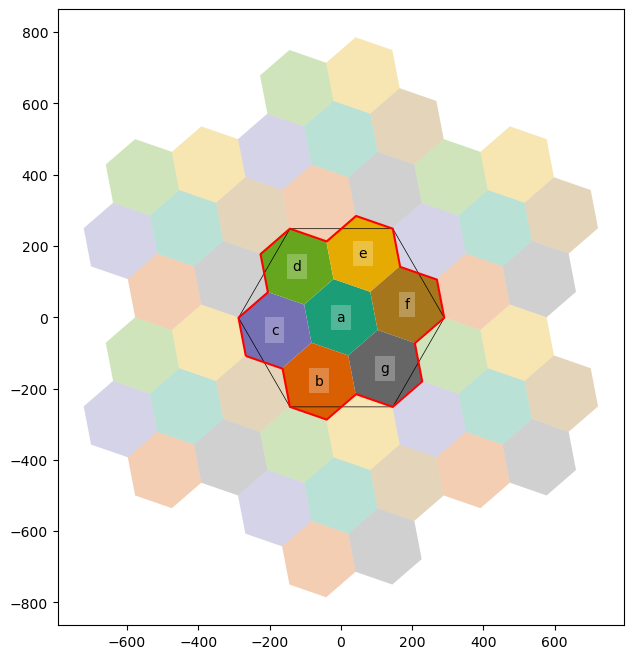

In [6]:
tile_unit.plot(r = 1)

In [7]:
tiling = Tiling(tile_unit, ak, prototile_margin = 10)
t30 = tiling.get_tiled_map()

/opt/miniconda3/envs/weaving/lib/python3.13/site-packages/shapely/constructive.py:996: RuntimeWarning: divide by zero encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


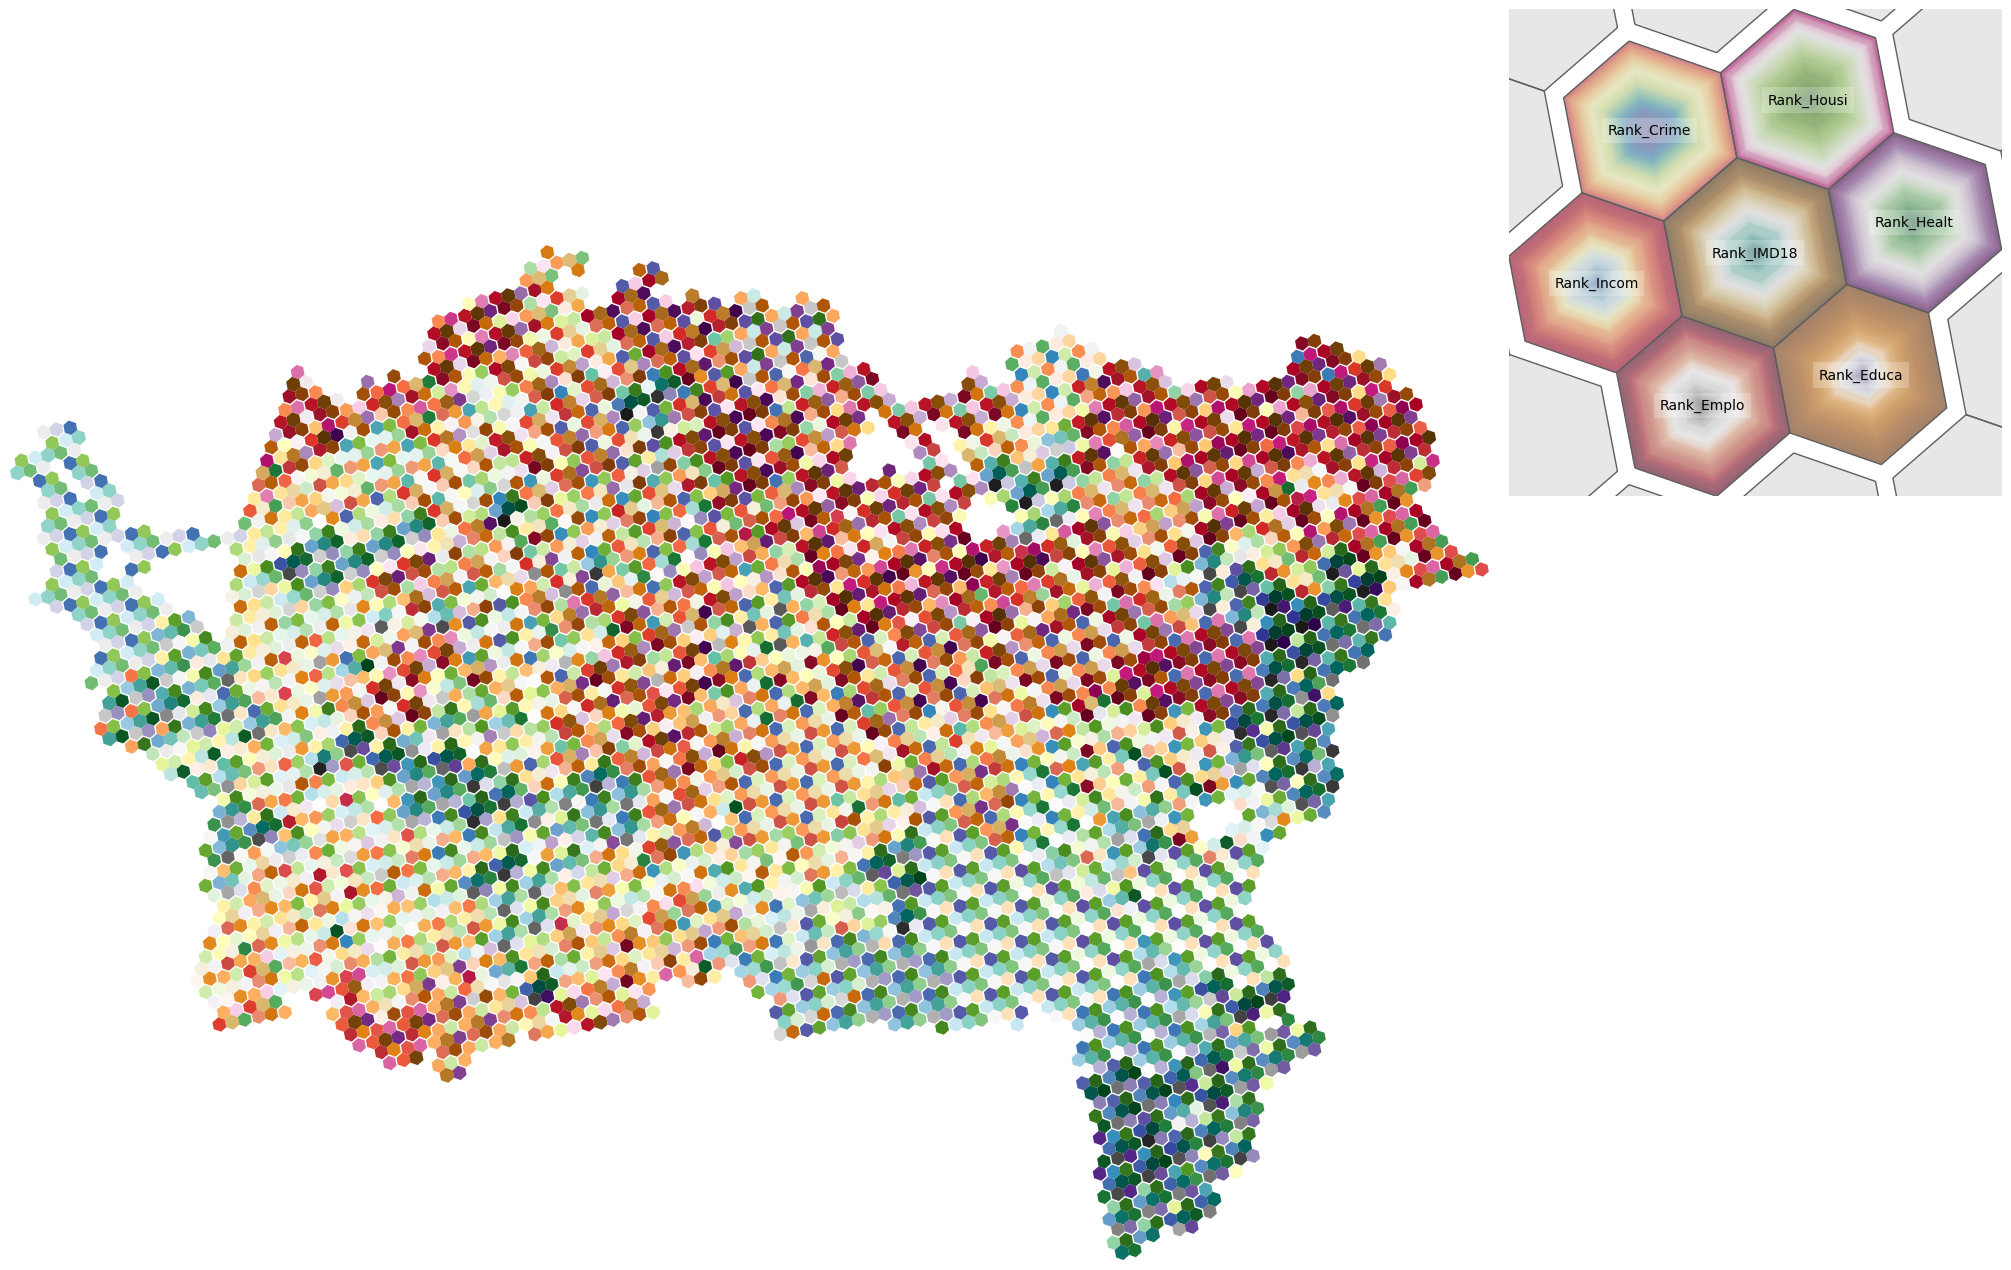

In [8]:
t30.variables = dict(zip(list("abcdefg"),
                         [x for x in ak if "Rank" in x]))
t30.colourmaps = dict(zip(t30.variables.values(), 
                          ("BrBG", "RdGy", "RdYlBu", "Spectral",
                           "PiYG", "PRGn", "PuOr", "viridis")))

fig = t30.render()

It seems likely a reader could cope with the 7 hexes shown.

## More 'levels'
We can apply a similar logic to make other rescaled hex tilings that are subdivisible into sets of tiles that are themselves 'super-hexes'. Much beyond one more level seems a stretch, but in principle many other levels are available.

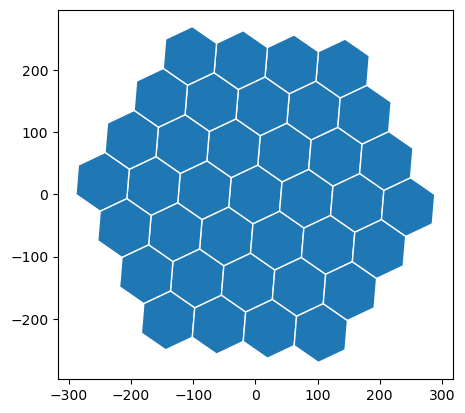

In [9]:
level = 3
ns = [1, 7, 19, 37, 61, 91]
sfs = [1 / np.sqrt(_) for _ in ns]
sf = sfs[level]

hex = tile_unit.prototile.geometry[0]
hex = scale(rotate(hex, 90), sf, sf)
hexes = [hex]

# vectors to displace hexes to position on a 'dissected' hex tiling
v1 = Point([d * sf, 0])
v2 = Point([d * sf * np.cos(np.pi * 2 / 3), 
            d * sf * np.sin(np.pi * 2 / 3)])

# iterate over levels
for i in range(1, level + 1):
    # each level needs #level additional hexes on each 'side'
    vs = [(i * v1.x + j * v2.x, i * v1.y + j * v2.y) for j in range(i)]
    # rotated 6 times
    extra_hexes = [translate(hex, v[0], v[1]) for v in vs]
    for rot in [_ * 60  for _ in range(6)]:
        hexes.extend([rotate(h, rot, origin = (0, 0)) for h in extra_hexes])

# Rotation angle to align with the original hex tile
rotation = (0 
            if level == 0
            else -np.degrees(np.arctan(1 / (level * 2 + 1) / np.sqrt(3))))

# inset scale factor
hexes = gpd.GeoSeries(hexes).rotate(
    rotation, origin = (0, 0))
# .scale(sf2, sf2, origin = (0, 0))  

ax = hexes.plot(edgecolor = "w")
# tile_unit.tiles.plot(ax = ax, facecolor = "#00000000", edgecolor = "k")

And subsets could be picked out as tile elements. Here just every other sub-hex, for example: 

<Axes: >

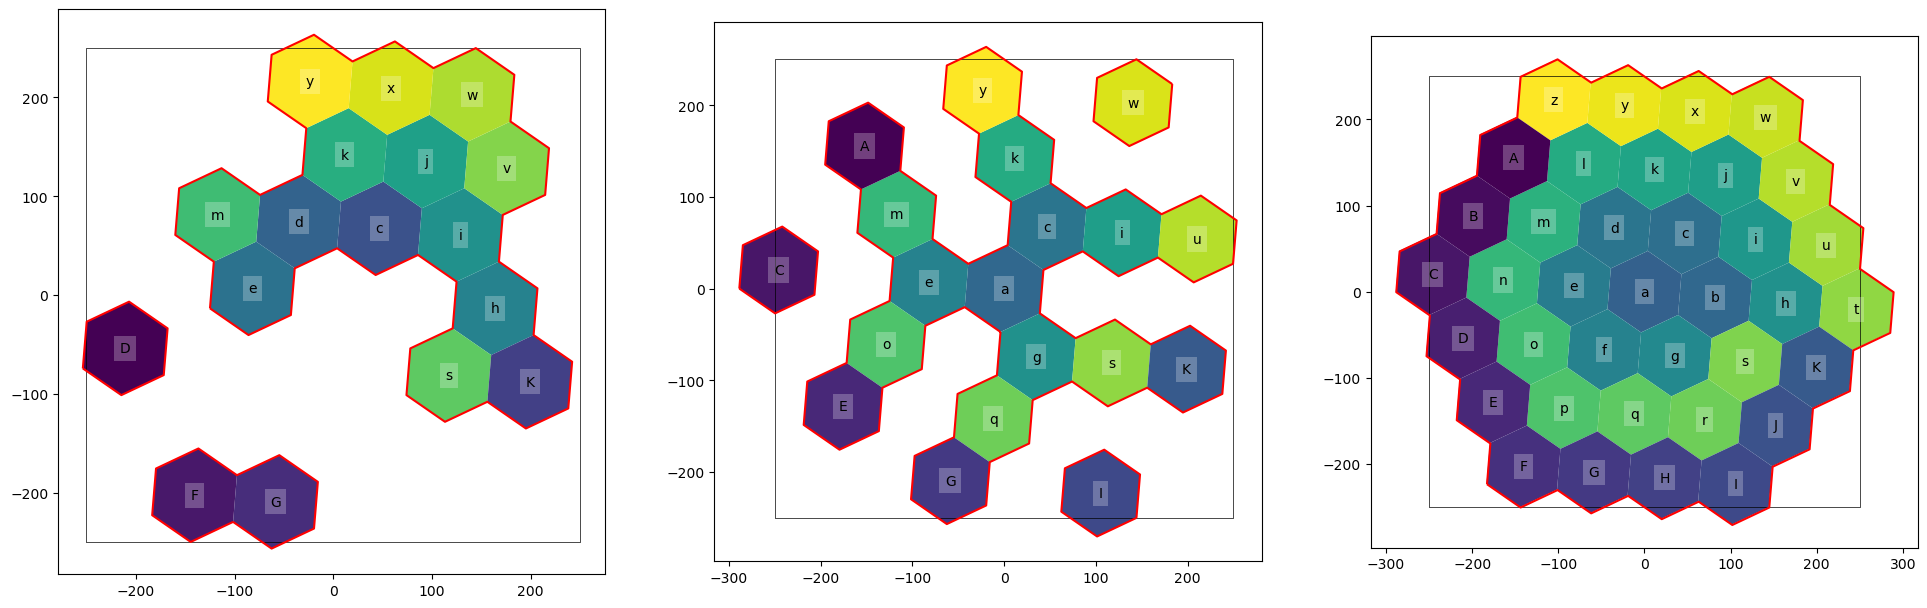

In [10]:

# some element_id labels
import string
import random

labels = string.ascii_letters

selector1 = random.choices([True, False], k = len(hexes))
selector2 = (100 * [True, False])[:len(hexes)]
selector3 = [True] * len(hexes)

unit1 = TileUnit(tile_shape = TileShape.HEXAGON, spacing = d, crs = ak.crs)
unit1.tiles = gpd.GeoDataFrame(
    data = {"tile_id": list(labels)[:len(hexes)]},
    geometry = gpd.GeoSeries(hexes), crs = ak.crs
)[selector1]
unit1.setup_regularised_prototile_from_tiles()

unit2 = TileUnit(tile_shape = TileShape.HEXAGON, spacing = d, crs = ak.crs)
unit2.tiles = gpd.GeoDataFrame(
    data = {"tile_id": list(labels)[:len(hexes)]},
    geometry = hexes, crs = ak.crs
)[selector2]
unit2.setup_regularised_prototile_from_tiles()

unit3 = TileUnit(tile_shape = TileShape.HEXAGON, spacing = d, crs = ak.crs)
unit3.tiles = gpd.GeoDataFrame(
    data = {"tile_id": list(labels)[:len(hexes)]},
    geometry = hexes, crs = ak.crs
)[selector3]
unit3.setup_regularised_prototile_from_tiles()

fig = pyplot.figure(figsize = (24, 8))
ax = fig.add_subplot(131)
unit1.plot(ax = ax, cmap = "viridis")

ax = fig.add_subplot(132)
unit2.plot(ax = ax, cmap = "viridis")

ax = fig.add_subplot(133)
unit3.plot(ax = ax, cmap = "viridis")


## Tile units as icons
Given a tile unit, it is also possible to use it as an icon, one per spatial unit.

To do this we set `as_icons = True` when we make the tiling.

In [11]:
selector = (7 * [True] + 12 * [False])

unit = TileUnit(base_shape = TileShape.HEXAGON, spacing = d, crs = ak.crs)
unit.tiles = gpd.GeoDataFrame(
    data = {"tile_id": list(labels)[:19]},
    geometry = hexes, crs = ak.crs
)[selector]
unit.setup_regularised_prototile_from_tiles()

icons = Tiling(unit, ak, as_icons = True)
icons_map = icons.get_tiled_map()

icons_map.variables = dict(zip(list("abcdefg"),
                           [x for x in ak if "Rank" in x]))
icons_map.colourmaps = dict(zip(t30.variables.values(), 
                                ("RdBu_r",) * 7))
                            # ("BrBG", "RdGy", "RdYlBu", "Spectral",
                            #  "PiYG", "PRGn", "PuOr", "viridis")))

/opt/miniconda3/envs/weaving/lib/python3.13/site-packages/shapely/constructive.py:996: RuntimeWarning: divide by zero encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


<Axes: >

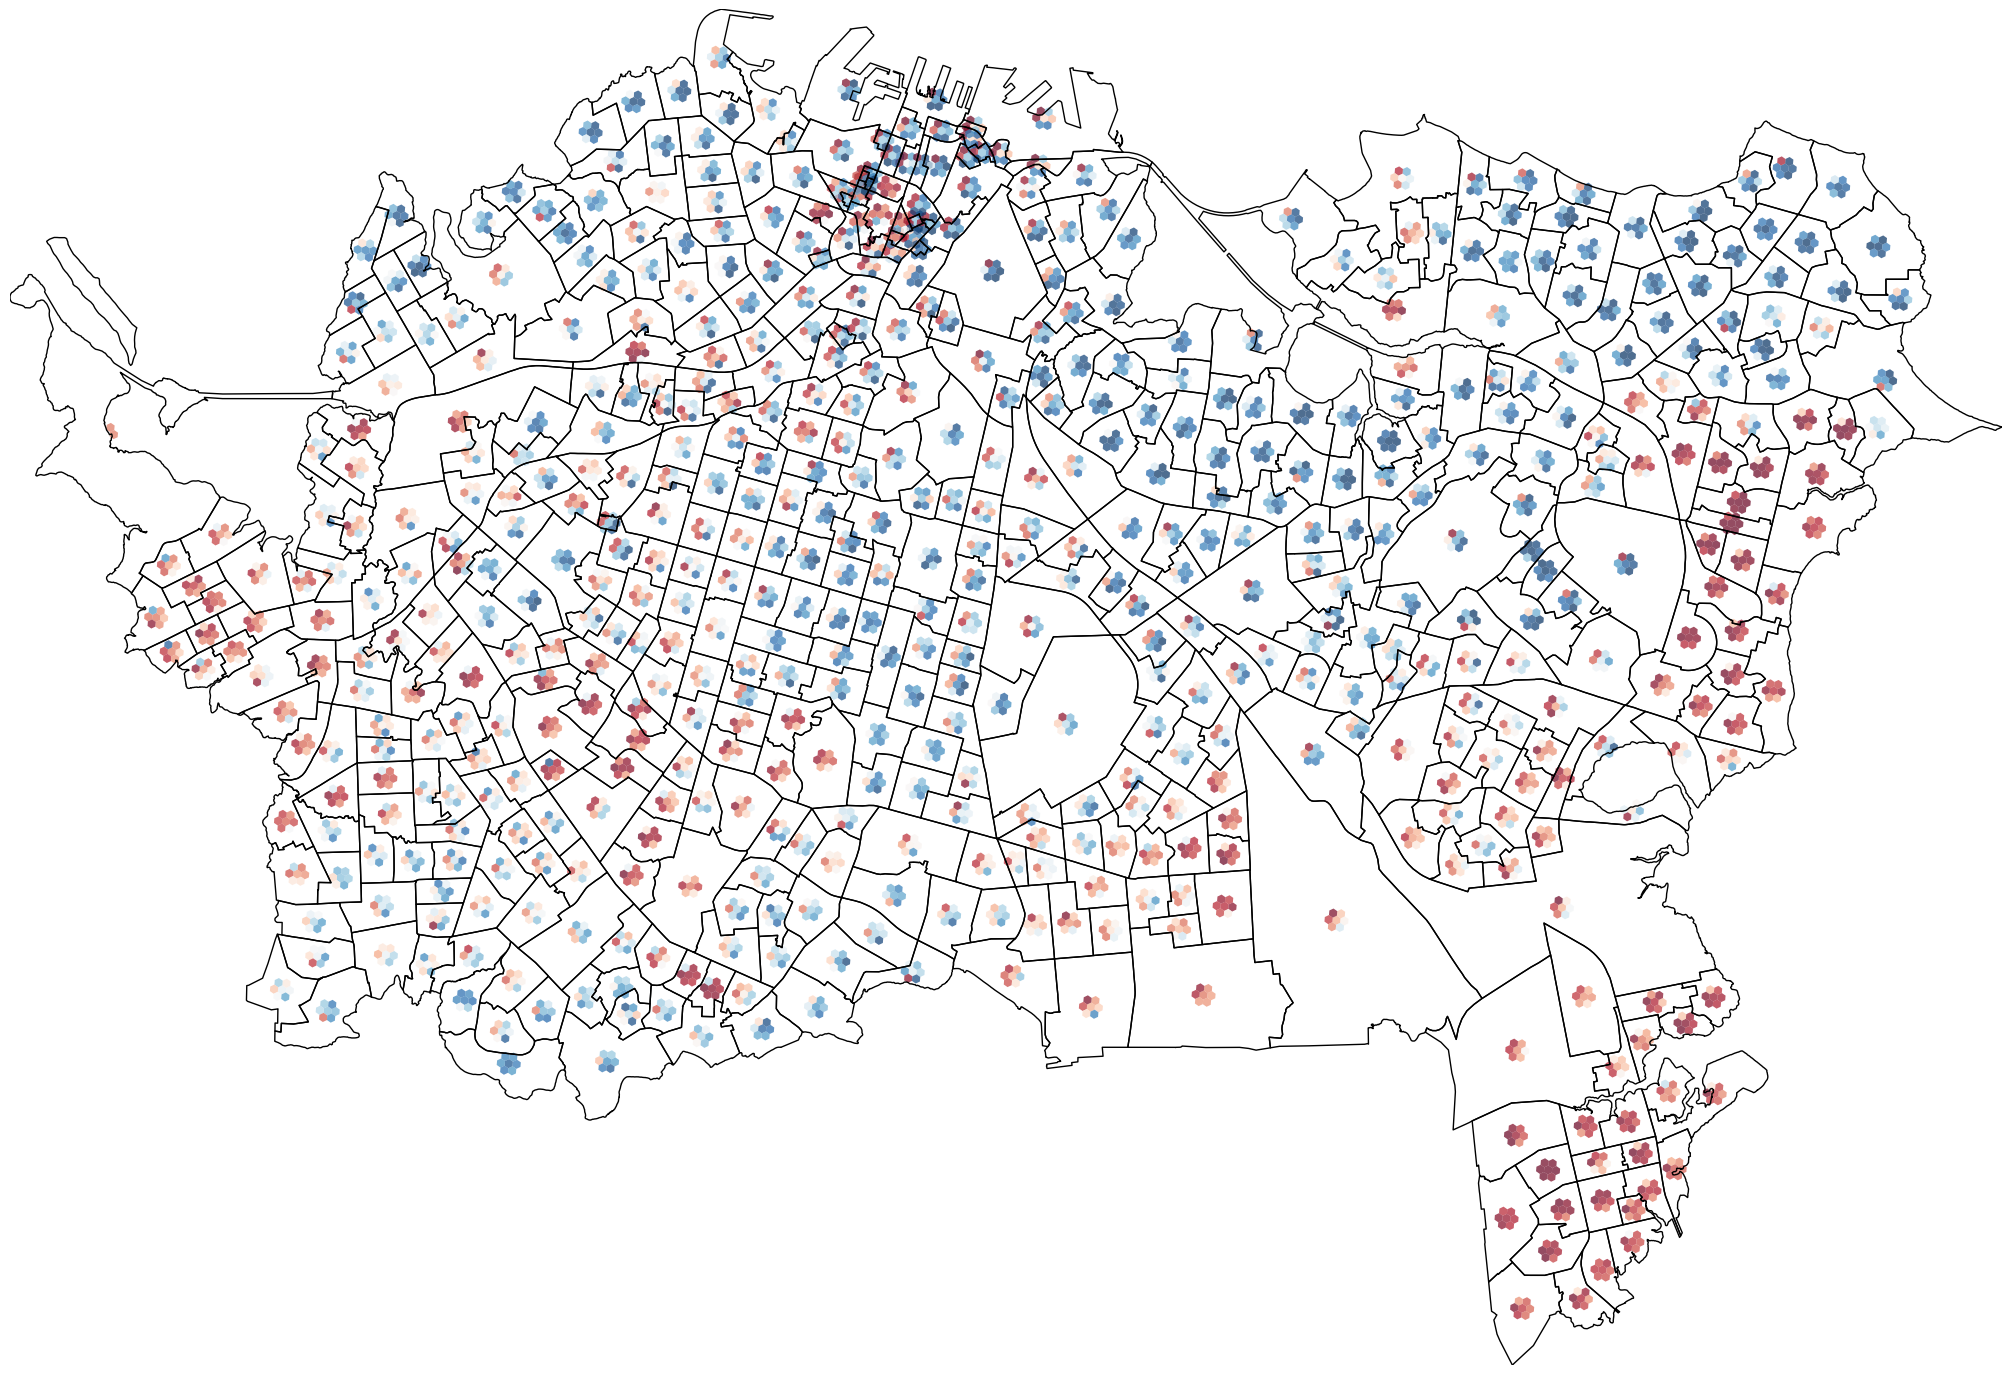

In [12]:
bb = ak.total_bounds
fig = icons_map.render(legend = False, alpha = 0.7)
fig.axes[0].set_xlim(bb[0], bb[2])
fig.axes[0].set_ylim(bb[1], bb[3])
ak.plot(ax = fig.axes[0], fc = "#00000000", ec = "k") 